# Student habits vs Academic performance

## Enunciado

Utilizando como base o dataset [Student habits v Academic performance](../datasets/student_habits_performance.csv):

1. Apenas com a observação dos dados por meio de tabelas e dataframe, apresente suas hipóteses;

2. Realize uma EDA da forma que julgar mais adequada;

3. Com base na EDA realizada, revise as suas hipóteses a respeito dos dados;

4. Construa um algoritmo de K-Means from scratch utilizando a linguagem Python

5. Apresente a justificativa de forma discursiva e por meio de cálculos, o valor de K utilizado;

6. Revise as hipóteses levantadas nos exercícios 1 e 2 e com base no algoritmo desenvolvido, apresente análise crítica a respeito das informações extraídas dos dados caso o algoritmo refute ou confirme as suas hipóteses;

Tarefas Extra:

7. Exercite sua habilidade de pesquisa e curadoria de informações e a partir de fontes próprias, escreva, com suas palavras, de maneira teórica e com o aprofundamento que achar adequado os algoritmos DBSCAM e Hierarchical Clustering;

8. Exercite sua habilidade de pesquisa e curadoria de informações e a partir de fontes próprias, escreva, com suas palavras, de maneira teórica e com o aprofundamento que achar adequado qual o algoritmo SotA para clustering. Apresente as referências utilizadas;

https://chatgpt.com/share/6821eda7-00f4-8006-9abd-43bdd7df4be1


## Setup


### Importando pacotes e dados


In [ ]:
# Importando pacotes

# Type hinting
from typing import Any, List, Tuple, Dict

# Implementação de K-Means
from sklearn.metrics import adjusted_rand_score
from sklearn.base import BaseEstimator, ClusterMixin

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Utilidades
import pickle

# Métricas
from sklearn.metrics import silhouette_score

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Modelos
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Importando dados
df = pd.read_csv('../datasets/student_habits_performance.csv')

In [3]:
# Criando cópia do dataset original sem coluna de Id
df_copy = df.drop('student_id', axis=1).copy(deep=True)

### Criando Dicionário de cores


In [4]:
# Criando dict de pallete
sns.set_theme(style='darkgrid')
sns.set_context('notebook', font_scale=1.2)
colors = sns.color_palette('Paired', len(df_copy.columns))
color_dict = {df_copy.columns[i]: colors[i] for i in range(len(df_copy.columns))}

### Declarações de funções


In [5]:
# Função para imprimir histograma dos dados
def dataframe_histograms(
    df: pd.DataFrame,
    color_dict: Dict[str, Tuple[float, float, float]],
    nrows: int,
    ncols: int,
    figsize: Tuple[int, int],
) -> None:
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.histplot(
            df[column],
            color=color_dict[column],
            ax=axes[i],
        )
        axes[i].set_title(f'Histogram {column}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Features distributions')
    plt.tight_layout()
    plt.show()

In [6]:
# Função para imprimir boxplots dos dados
def dataframe_boxplots(
    df: pd.DataFrame,
    color_dict: Dict[str, Tuple[float, float, float]],
    nrows: int,
    ncols: int,
    figsize: Tuple[int, int],
) -> None:
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.boxplot(df[column], orient='h', color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Boxplot {column}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Features boxplots')
    plt.tight_layout()
    plt.show()

In [7]:
# Função para imprimir visualização de correlação
def plot_correlation(corr_df: pd.Series, figsize: Tuple[int, int]) -> None:
    plt.figure(figsize=figsize)
    sns.barplot(
        x=corr_df.values,
        y=corr_df.index,
        hue=corr_df.index,
        palette='Paired',
    )
    plt.title('Correlation of columns and diabetes diagnose (Outcome)', fontsize=12)
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

In [8]:
# Função para contar valores únicos por coluna
def count_unique_values(df: pd.DataFrame, features: List[str]) -> None:
    for feature in features:
        unique_value_counts = df_copy[feature].value_counts().to_dict()

        print(
            '-' * 50,
            f'Feature "{feature}": {len(unique_value_counts)} valores únicos',
            sep='\n',
        )

        for value, count in unique_value_counts.items():
            print(f'{value} : {count}')

## Hipóteses inicias a partir de inspeção de dados

Analisando o dataset apenas com o método `.head`, surge como hipótese de que estudantes com menos tempo em redes sociais, netflix, que não tem empregos, dormem melhor, com melhor saúde mental, mais horas de estudo tem melhor desempenho acadêmico.


In [9]:
# Visualizando dados de forma geral
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


## EDA

O overview dos dados serviu para verificar a integridade do dataset como um todo, onde foram verificados os tipos de dados de cada feature, uma análise descritiva das features numéricas, e enumeração de valores únicos nas colunas categóricas com suas frequências.

Em seguida foi feita uma análise sobre a quantidade de dados faltantes, revelando um total de $91$ valores faltantes na coluna `parental_education_level`, sendo essa a única feature com valores `NaN`. Esses dados foram completados com o valor `'Not Informed'`.

As visualizações foram efetivas em demonstrar alguns fatos sobre os dados. Primeiramente, não existe uma grande quantidade de outliers, não sendo grande preocupação no dataset. Em um segundo momento foi possível fazer uma análise sobre as assimetrias das distribuições, com destaques para as features `attendance_percentage`, `exam_score`, e `extracurricular_participation` com assimetrias à direita, e as features `netflix_hours` `part_time_job`, e `diet_quality` com assimetrias à esquerda. Além disso foi feito um _scatter plot_ para analisar a distribuição das notas com horas de estudo, já reforçando a hipótese de correlação positiva relevante entre as duas features.

Para finalizar o EDA, foi feita uma correlação entre as variáveis (após codificação OneHot, feita com a função `get_dummies` do _Pandas_). A partir dessa correlação é possível corroborar mais alguns pontos da hipótese original sobre os dados:

- A feature com maior correlação à performance estudantil é o número de horas estudadas (~$0.82$), seguida pela nota da saúde mental do estudante (~$0.3$).

- As features com correlação mais negativa em relação à nota do exame são justamente a quantidade de horas de netflix por dia (~$0.17$), e a quantidade de horas de rede social por dia (~$0.16$).

Após a análise exploratória dos dados, foi possível encontrar uma série de fatores que corroboram a hipótese inicial acima.


### Overview dos dados


In [10]:
# Informações gerais sobre os dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   student_id                     1000 non-null   object 
 1   age                            1000 non-null   int64  
 2   gender                         1000 non-null   object 
 3   study_hours_per_day            1000 non-null   float64
 4   social_media_hours             1000 non-null   float64
 5   netflix_hours                  1000 non-null   float64
 6   part_time_job                  1000 non-null   object 
 7   attendance_percentage          1000 non-null   float64
 8   sleep_hours                    1000 non-null   float64
 9   diet_quality                   1000 non-null   object 
 10  exercise_frequency             1000 non-null   int64  
 11  parental_education_level       909 non-null    object 
 12  internet_quality               1000 non-null   ob

In [11]:
# Descrevendo dados numéricos
df.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [12]:
# Separando features em numéricas e categóricas
cat_features = df.select_dtypes(include=['object']).columns.drop('student_id').tolist()

num_features = df.select_dtypes(exclude=['object']).columns.tolist()

In [13]:
# Visualizando valores únicos por feature
count_unique_values(df, cat_features)

--------------------------------------------------
Feature "gender": 3 valores únicos
Female : 481
Male : 477
Other : 42
--------------------------------------------------
Feature "part_time_job": 2 valores únicos
No : 785
Yes : 215
--------------------------------------------------
Feature "diet_quality": 3 valores únicos
Fair : 437
Good : 378
Poor : 185
--------------------------------------------------
Feature "parental_education_level": 3 valores únicos
High School : 392
Bachelor : 350
Master : 167
--------------------------------------------------
Feature "internet_quality": 3 valores únicos
Good : 447
Average : 391
Poor : 162
--------------------------------------------------
Feature "extracurricular_participation": 2 valores únicos
No : 682
Yes : 318


### Lidando com valores nulos


In [14]:
# Contando valores nulos
df.isna().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

In [15]:
# Completando valores nulos
df_copy['parental_education_level'] = df_copy['parental_education_level'].fillna(
    'Not Informed'
)

In [16]:
# Contando valores nulos
df_copy.isna().sum()

age                              0
gender                           0
study_hours_per_day              0
social_media_hours               0
netflix_hours                    0
part_time_job                    0
attendance_percentage            0
sleep_hours                      0
diet_quality                     0
exercise_frequency               0
parental_education_level         0
internet_quality                 0
mental_health_rating             0
extracurricular_participation    0
exam_score                       0
dtype: int64

In [17]:
# Reanalisando valores únicos por feature
count_unique_values(df_copy, cat_features)

--------------------------------------------------
Feature "gender": 3 valores únicos
Female : 481
Male : 477
Other : 42
--------------------------------------------------
Feature "part_time_job": 2 valores únicos
No : 785
Yes : 215
--------------------------------------------------
Feature "diet_quality": 3 valores únicos
Fair : 437
Good : 378
Poor : 185
--------------------------------------------------
Feature "parental_education_level": 4 valores únicos
High School : 392
Bachelor : 350
Master : 167
Not Informed : 91
--------------------------------------------------
Feature "internet_quality": 3 valores únicos
Good : 447
Average : 391
Poor : 162
--------------------------------------------------
Feature "extracurricular_participation": 2 valores únicos
No : 682
Yes : 318


### Visualizações


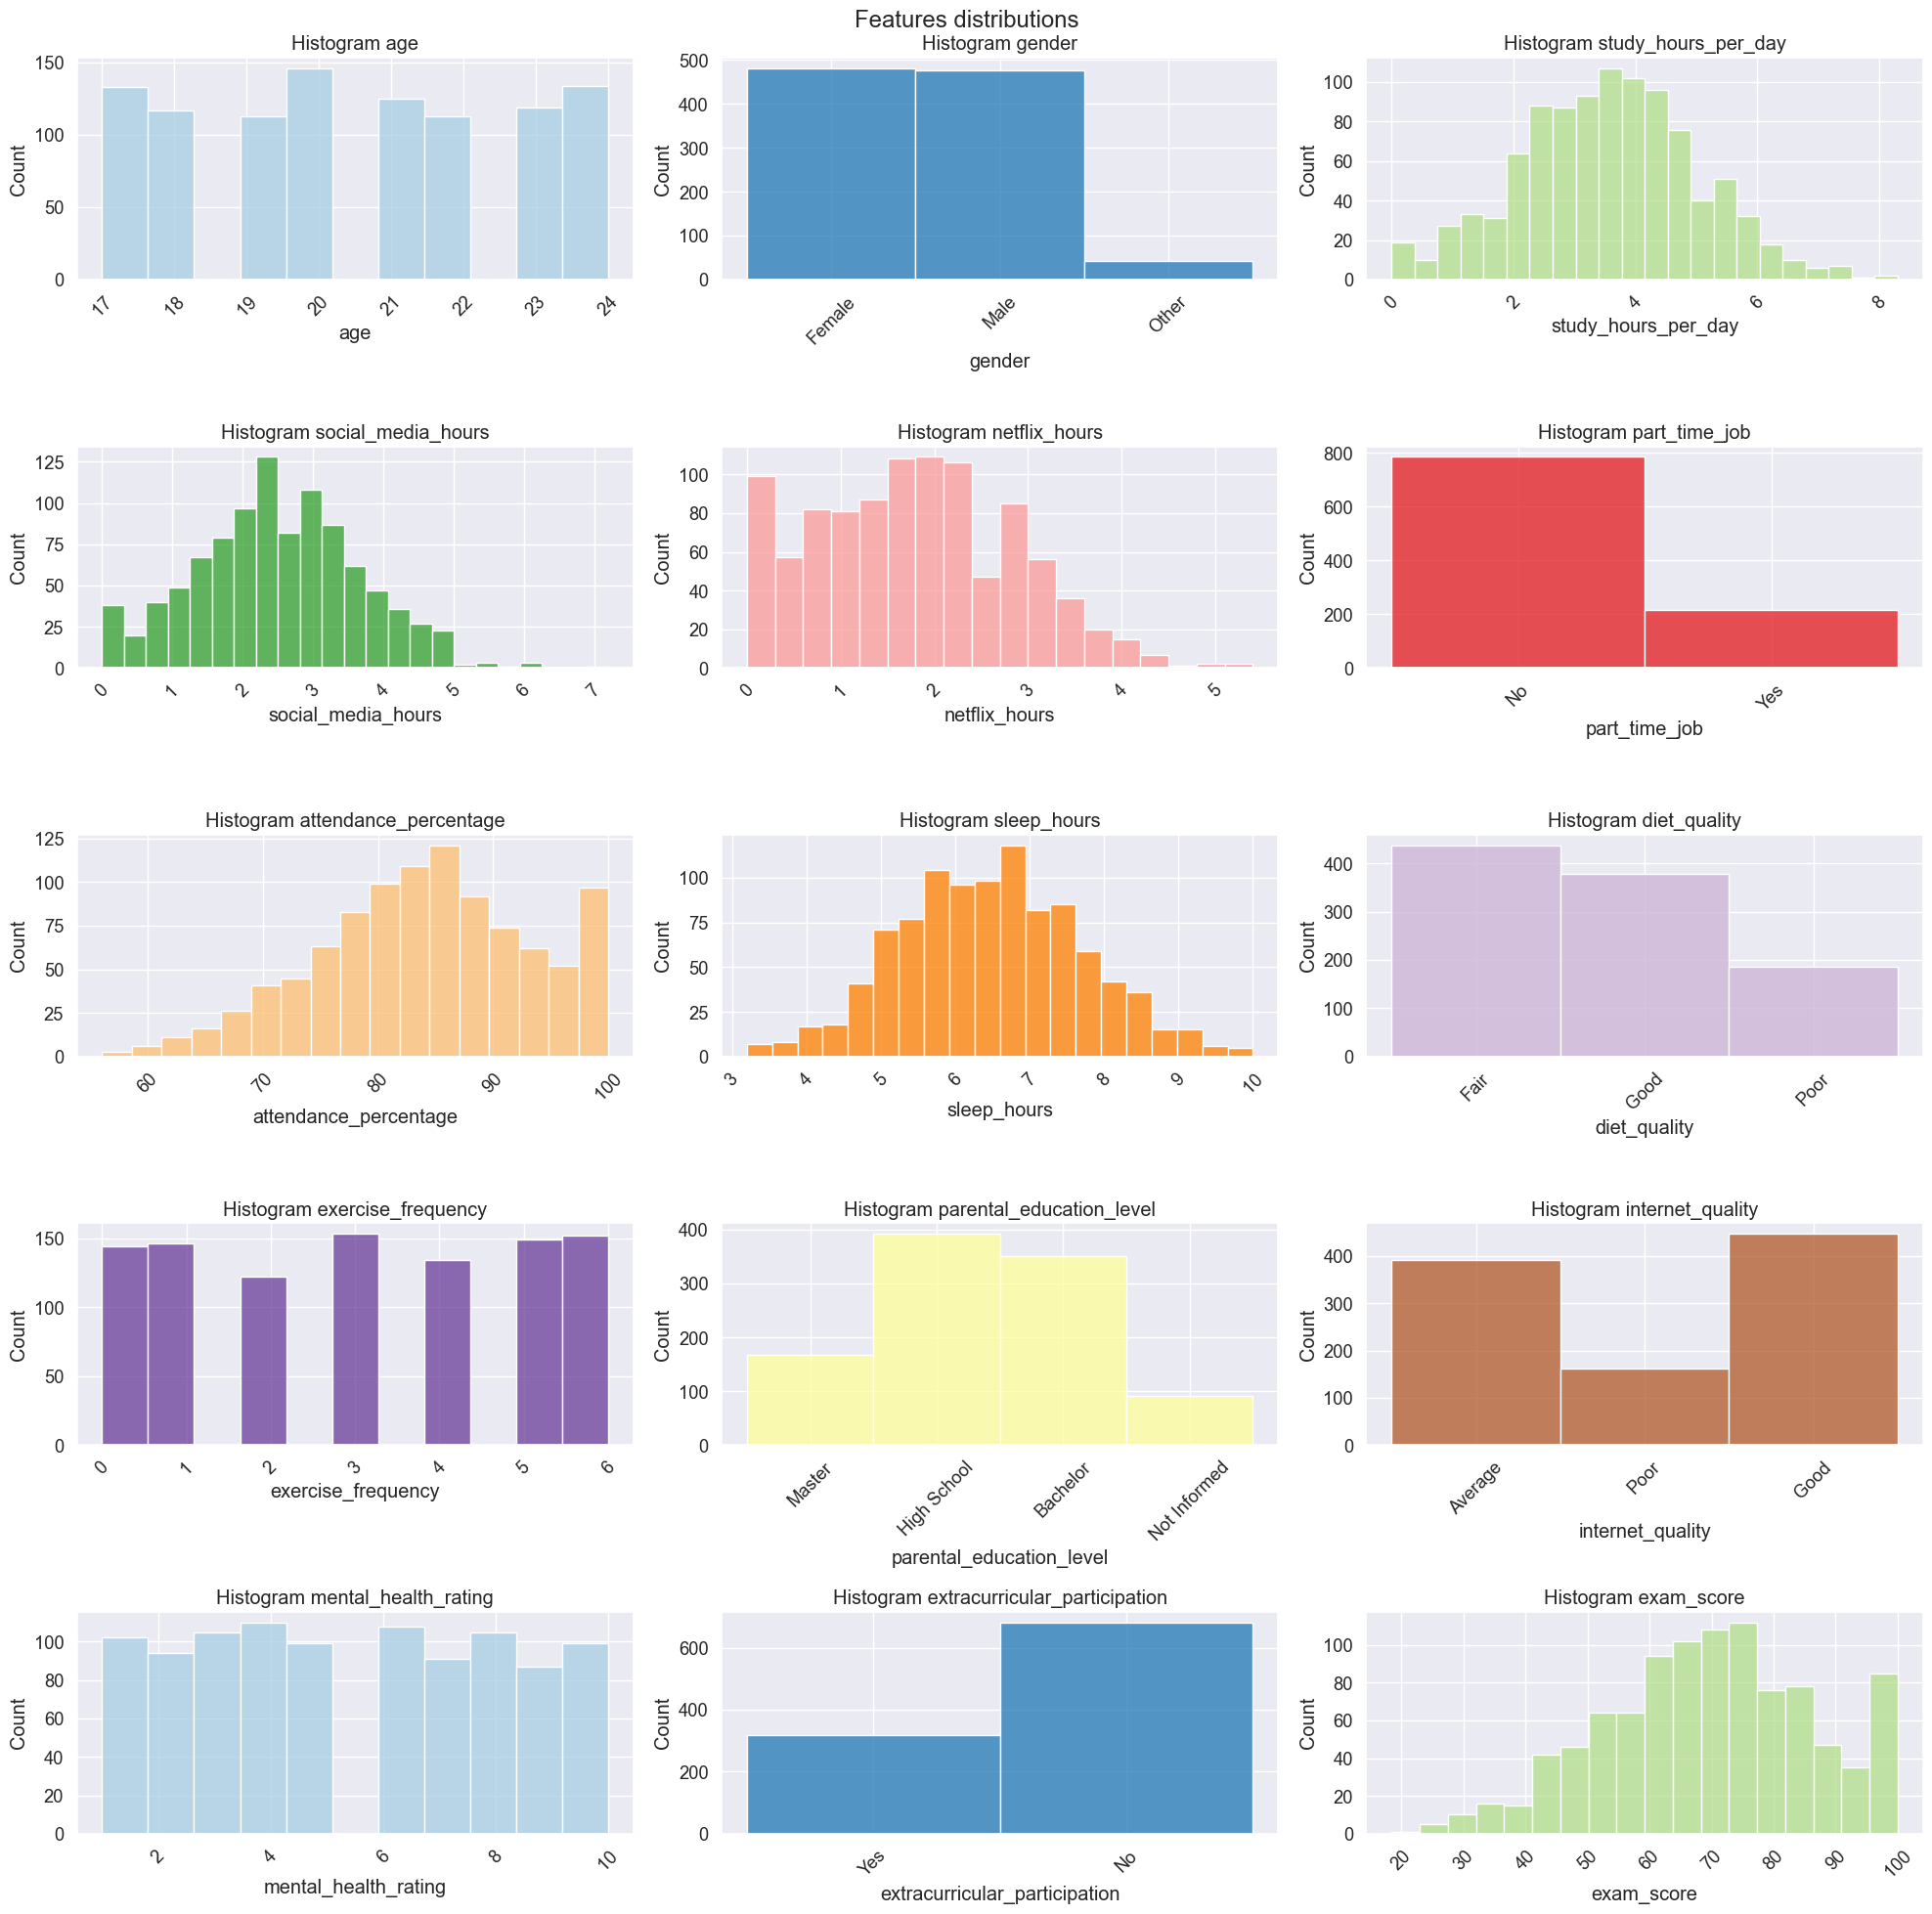

In [18]:
# Histogramas das features
dataframe_histograms(
    df_copy,
    color_dict=color_dict,
    nrows=5,
    ncols=3,
    figsize=(20, 20),
)

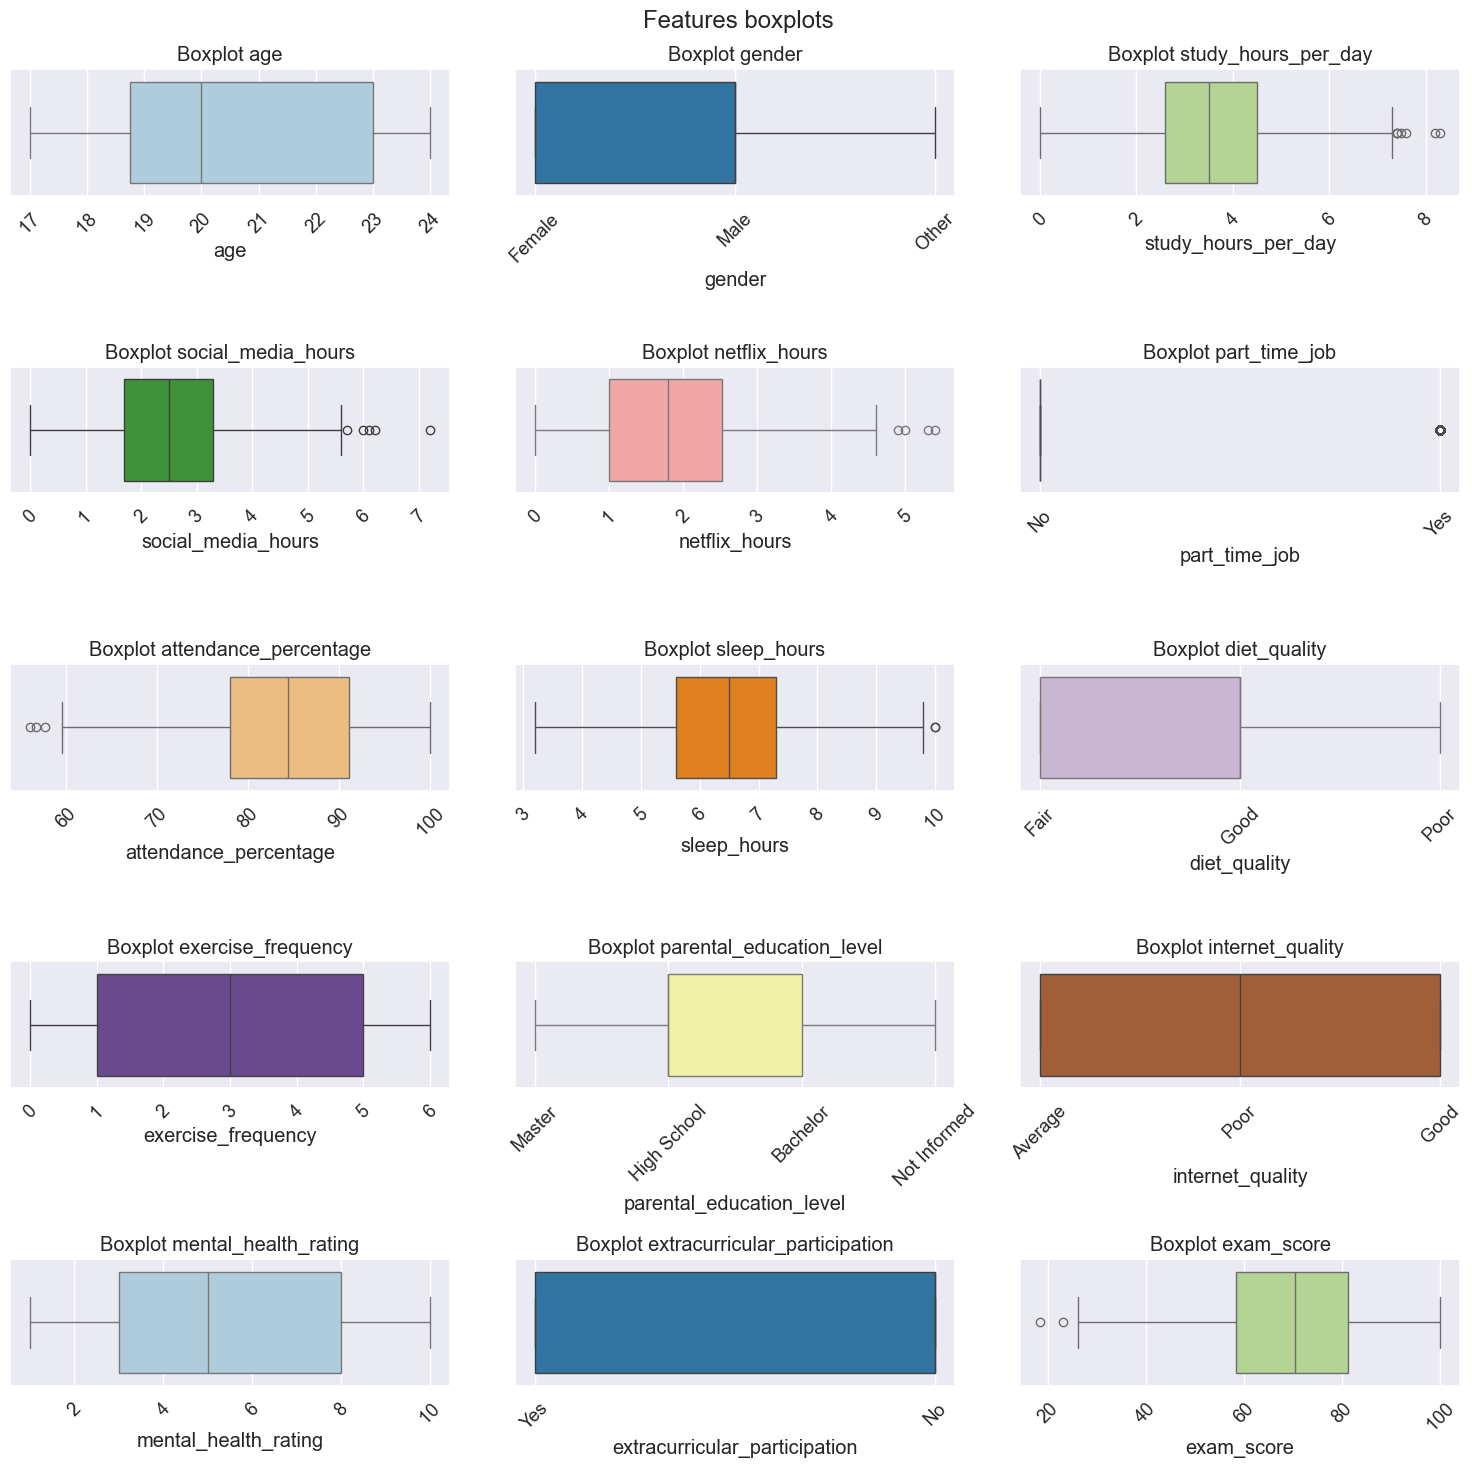

In [19]:
# Boxplots
dataframe_boxplots(
    df_copy,
    color_dict=color_dict,
    nrows=5,
    ncols=3,
    figsize=(15, 15),
)

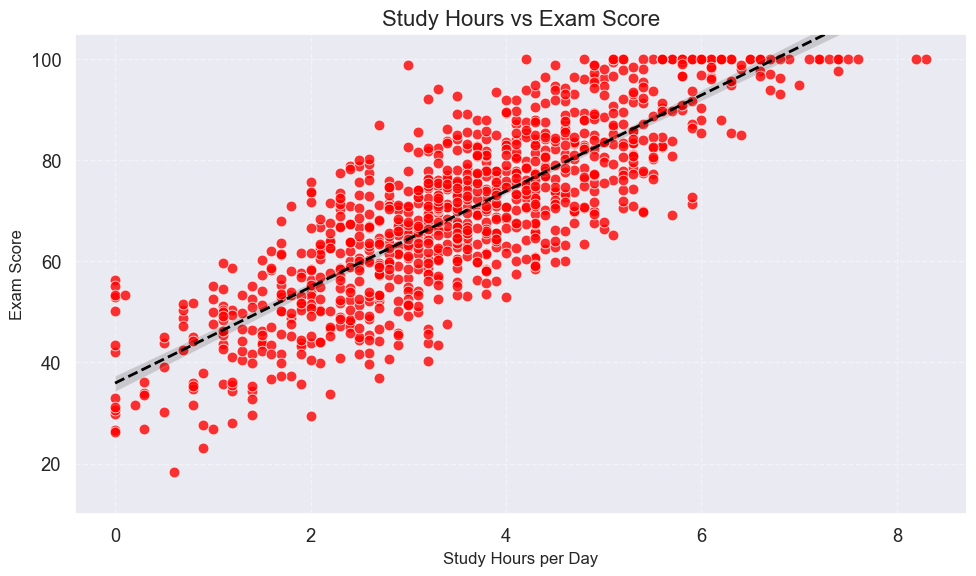

In [20]:
# Scatter plot horas de estudo x nota final
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_copy,
    x='study_hours_per_day',
    y='exam_score',
    color='red',
    s=60,
    edgecolor='w',
    alpha=0.8,
)

sns.regplot(
    data=df_copy,
    x='study_hours_per_day',
    y='exam_score',
    scatter=False,
    color='black',
    line_kws={"linewidth": 2, "linestyle": "dashed"},
)
plt.ylim(10, 105)
plt.title('Study Hours vs Exam Score', fontsize=16)
plt.xlabel('Study Hours per Day', fontsize=12)
plt.ylabel('Exam Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

### Codificando dados

Foi criado um dataset codificado de modo a possibilitar o cálculo de correlação (feito na próxima seção).


In [21]:
# Criando nova cópia
encoded_df = df_copy.copy(deep=True)

In [22]:
# low_card_cols = ['part_time_job', 'extracurricular_participation']
encoded_df = pd.get_dummies(encoded_df, columns=cat_features, drop_first=True)

encoded_df.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
0,23,0.0,1.2,1.1,85.0,8.0,6,8,56.2,False,False,False,False,False,False,True,False,False,False,True
1,20,6.9,2.8,2.3,97.3,4.6,6,8,100.0,False,False,False,True,False,True,False,False,False,False,False
2,21,1.4,3.1,1.3,94.8,8.0,1,1,34.3,True,False,False,False,True,True,False,False,False,True,False
3,23,1.0,3.9,1.0,71.0,9.2,4,1,26.8,False,False,False,False,True,False,True,False,True,False,True
4,19,5.0,4.4,0.5,90.9,4.9,3,1,66.4,False,False,False,False,False,False,True,False,True,False,False


### Correlação


In [23]:
# Calculando correlação
correlation_df = encoded_df.corr()
correlation_df

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
age,1.000000,0.003971,-0.009151,-0.001174,-0.026055,0.037482,-0.003836,-0.045101,-0.008907,0.025562,0.015309,-0.011680,-0.002006,-0.010192,-0.046363,-0.004842,0.031171,0.029987,0.025087,-0.004993
study_hours_per_day,0.003971,1.000000,0.020282,-0.031158,0.026264,-0.027757,-0.028701,-0.003768,0.825419,-0.025634,0.008814,-0.029133,-0.003565,-0.066777,0.000643,0.009009,0.024490,0.001514,-0.026465,-0.003264
social_media_hours,-0.009151,0.020282,1.000000,0.011477,0.040479,0.018236,-0.037319,0.001496,-0.166733,-0.004995,0.015609,0.021224,0.026084,0.011390,0.028569,0.007508,0.002372,0.046071,-0.010402,-0.018597
netflix_hours,-0.001174,-0.031158,0.011477,1.000000,-0.002092,-0.000935,-0.006448,0.008034,-0.171779,0.000937,0.046266,0.009207,0.002406,0.021463,0.026835,-0.007959,-0.031362,0.030498,-0.036854,-0.005125
attendance_percentage,-0.026055,0.026264,0.040479,-0.002092,1.000000,0.013756,-0.007857,-0.018745,0.089836,-0.024108,-0.001184,-0.041771,-0.061024,0.033262,-0.026410,-0.072545,0.084574,-0.021596,0.049536,-0.017778
sleep_hours,0.037482,-0.027757,0.018236,-0.000935,0.013756,1.000000,0.019769,-0.006508,0.121683,-0.024235,0.057166,0.001645,-0.024224,0.034733,-0.021355,0.001298,-0.010152,-0.002190,-0.006988,0.027693
exercise_frequency,-0.003836,-0.028701,-0.037319,-0.006448,-0.007857,0.019769,1.000000,-0.000242,0.160107,0.068207,-0.009269,-0.021679,0.024576,0.020647,0.029885,-0.039751,-0.015152,-0.030575,0.027076,-0.005681
mental_health_rating,-0.045101,-0.003768,0.001496,0.008034,-0.018745,-0.006508,-0.000242,1.000000,0.321523,-0.006279,0.002810,0.013539,0.056837,0.019880,0.011014,-0.087748,-0.031590,-0.056385,0.019114,-0.004741
exam_score,-0.008907,0.825419,-0.166733,-0.171779,0.089836,0.121683,0.160107,0.321523,1.000000,-0.013191,0.012976,-0.026608,-0.010857,-0.041602,-0.002583,-0.040177,0.008108,-0.050804,0.003016,0.000881
gender_Male,0.025562,-0.025634,-0.004995,0.000937,-0.024108,-0.024235,0.068207,-0.006279,-0.013191,1.000000,-0.199963,0.031409,0.019382,-0.027044,0.028773,0.007198,-0.044601,-0.033097,0.074586,-0.007248


netflix_hours                           -0.171779
social_media_hours                      -0.166733
internet_quality_Good                   -0.050804
diet_quality_Poor                       -0.041602
parental_education_level_Master         -0.040177
part_time_job_Yes                       -0.026608
gender_Male                             -0.013191
diet_quality_Good                       -0.010857
age                                     -0.008907
parental_education_level_High School    -0.002583
extracurricular_participation_Yes        0.000881
internet_quality_Poor                    0.003016
parental_education_level_Not Informed    0.008108
gender_Other                             0.012976
attendance_percentage                    0.089836
sleep_hours                              0.121683
exercise_frequency                       0.160107
mental_health_rating                     0.321523
study_hours_per_day                      0.825419
Name: exam_score, dtype: float64


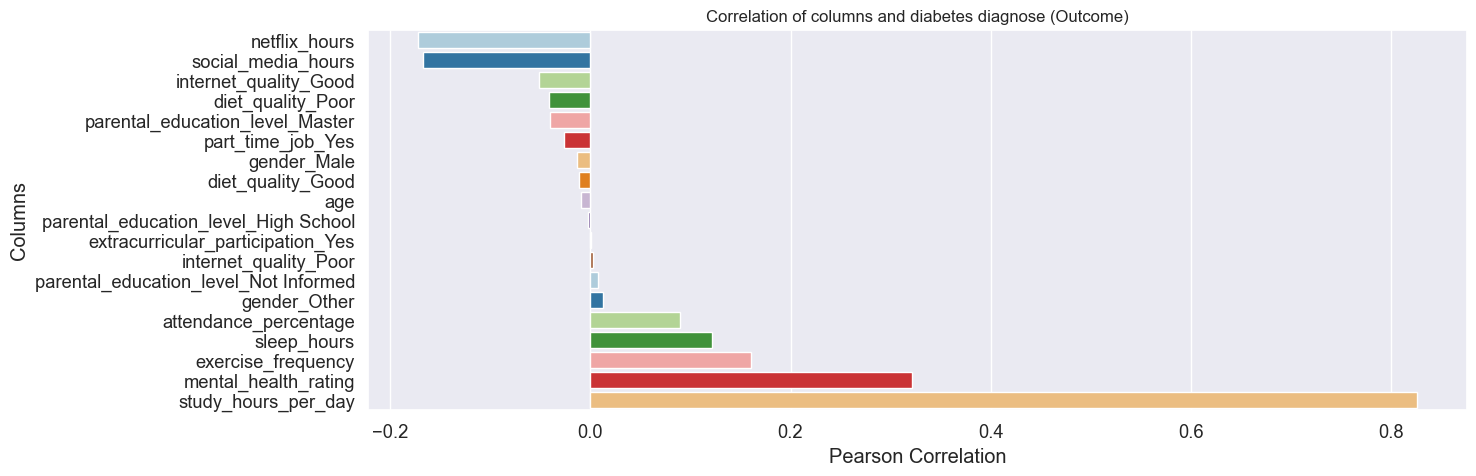

In [24]:
# Obtendo coluna de correlação
corr_income = correlation_df['exam_score'].sort_values().drop('exam_score')

print(corr_income)

# Criando plot
plot_correlation(corr_income, figsize=(15, 5))

gender_Male -0.013191
diet_quality_Good -0.010857
age -0.008907
parental_education_level_High School -0.002583
extracurricular_participation_No -0.000881
extracurricular_participation_Yes 0.000881
internet_quality_Poor 0.003016
gender_Female 0.007977
parental_education_level_Not Informed 0.008108
gender_Other 0.012976
part_time_job_No 0.026608
parental_education_level_Bachelor 0.029172


### Organizando dados de treinamento


In [25]:
# Separando dados em features e label ('exam_score')
X = df_copy.drop('exam_score', axis=1)
y = df_copy['exam_score']

## Implementação de K-Means from scratch

K-Means é um algoritmo de machine learning usado para encontrar padrões em grupos de dados. K-Means funciona de forma iterativa, o que significa que ele passa por uma série de iterações nos dados para atualizar os centroides, e chegar às labels finais de cluster.

O algoritmo pode ser descrito com os seguintes passos

1. Especificar o número de clusters que devem ser usados (referidos no algoritmo como `k`)

2. Inicializar de forma aleatória os centroides (no algoritmo `cluster_centers_` para conformidade com a biblioteca sklearn) para cada cluster.

3. Determinar quais pontos pertencem a cada cluster ao encontrar o centroide mais próximo a cada ponto dos dados.

4. Atualizar os centroides baseado na média geométrica de todos os dados de dado cluster.

5. Repetir os passos 3 e 4 até que os centroides parem de mudar.

O passo 5 é a origem da natureza iterativa do algoritmo.

O algoritmo foi implementado com intuito de compatibilidade com Pipelines da biblioteca `sklearn`. Para tal foram implementados os métodos `fit`, `transform`, `predict`, e suas combinações, `fit_predict`, e `fit_transform`.

[Vídeo referência para o algoritmo usado](https://www.youtube.com/watch?v=5w5iUbTlpMQ)


In [26]:
# Implementação de K-Means
class KMeansClustering(BaseEstimator, ClusterMixin):
    def __init__(
        self,
        k: int = 3,
        max_iter: int = 200,
        conv_thresh: float = 1e-4,
        random_state: int = None,
    ) -> None:
        self.k = k
        self.max_iter = max_iter
        self.conv_thresh = conv_thresh
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None

    @staticmethod
    def euclidean_distance(data_point, centroids):
        return np.sqrt(np.sum(np.square(centroids - data_point), axis=1))

    def fit(
        self,
        X: np.ndarray | pd.DataFrame,
        y: Any = None,
    ) -> 'KMeansClustering':
        X = X.values if isinstance(X, pd.DataFrame) else X

        rng = np.random.default_rng(self.random_state)

        self.cluster_centers_ = rng.uniform(
            low=np.amin(X, axis=0),
            high=np.amax(X, axis=0),
            size=(
                self.k,
                X.shape[1],
            ),
        )

        for _ in range(self.max_iter):
            y = []
            cluster_indices = []
            cluster_centers = []

            for data_point in X:
                distances = self.euclidean_distance(
                    data_point=data_point,
                    centroids=self.cluster_centers_,
                )
                cluster_num = np.argmin(distances)
                y.append(cluster_num)

            y = np.array(y)
            self.labels_ = y

            for i in range(self.k):
                cluster_indices.append(np.argwhere(y == i))

            for i, indices in enumerate(cluster_indices):
                if len(indices) == 0:
                    cluster_centers.append(self.cluster_centers_[i])
                else:
                    cluster_centers.append(np.mean(X[indices], axis=0)[0])

            new_centroids = np.array(cluster_centers)

            if np.max(self.cluster_centers_ - new_centroids) < 1e-4:
                break

            self.cluster_centers_ = new_centroids

        return self

    def predict(self, X: np.ndarray | pd.DataFrame) -> np.ndarray:

        X = X.values if isinstance(X, pd.DataFrame) else X

        predictions = []
        for data_point in X:
            distances = self.euclidean_distance(data_point, self.cluster_centers_)
            predictions.append(np.argmin(distances))
        return np.array(predictions)

    def fit_predict(self, X: np.ndarray | pd.DataFrame, y: Any = None) -> np.ndarray:
        self.fit(X)
        return self.labels_

    def transform(self, X: np.ndarray | pd.DataFrame) -> np.ndarray:

        X = X.values if isinstance(X, pd.DataFrame) else X

        distances = np.array(
            [self.euclidean_distance(x, self.cluster_centers_) for x in X]
        )
        return distances

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def score(
        self, X: np.ndarray | pd.DataFrame, y: np.ndarray | pd.DataFrame = None
    ) -> float:

        X = X.values if isinstance(X, pd.DataFrame) else X

        distances = self.transform(X)
        min_distances = np.min(distances, axis=1)
        unsupervised_score = -np.sum(np.square(min_distances))

        if y is not None:
            predicted_labels = self.predict(X)
            supervised_score = adjusted_rand_score(y, predicted_labels)
            return supervised_score

        return unsupervised_score

## Justificativa do valor de $K$

Métodos para determinar K:

- Elbow Method (WCSS vs.K): procure o “cotovelo” na curva de soma de quadrados dentro do cluster [link](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/?utm_source=chatgpt.com)

- Silhouette Score: avalia coesão e separação dos clusters; valores mais altos indicam clusters bem definidos [link](https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/?utm_source=chatgpt.com)

- Gap Statistic: compara inércia do seu dataset com dataset de referência aleatório.


In [27]:
# Separando features em numéricas e categóricas
cat_features = df_copy.select_dtypes(include=['object']).columns.tolist()

num_features = (
    df_copy.select_dtypes(exclude=['object'])
    .drop('exam_score', axis=1)
    .columns.tolist()
)

In [28]:
# Criando Pipelines

# Pipeline categórica
cat_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False)),
    ]
)

# Pipeline numérica
num_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
    ]
)

# Definindo transformador de pré-processamento
preprocessor = ColumnTransformer(
    [
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features),
    ],
)

model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.75)),
        ('kmeans', KMeansClustering(max_iter=500, conv_thresh=1e-5, random_state=42)),
    ]
)

In [29]:
# Transformando dados
data = preprocessor.fit_transform(X)

In [30]:
# Definindo pca para teste de cotovelo
pca = PCA(5)
data_pca = pca.fit_transform(data)

In [31]:
pd.DataFrame(data_pca).mean()

0    8.948398e-17
1   -7.949197e-17
2    2.442491e-18
3    9.325873e-18
4   -2.753353e-17
dtype: float64

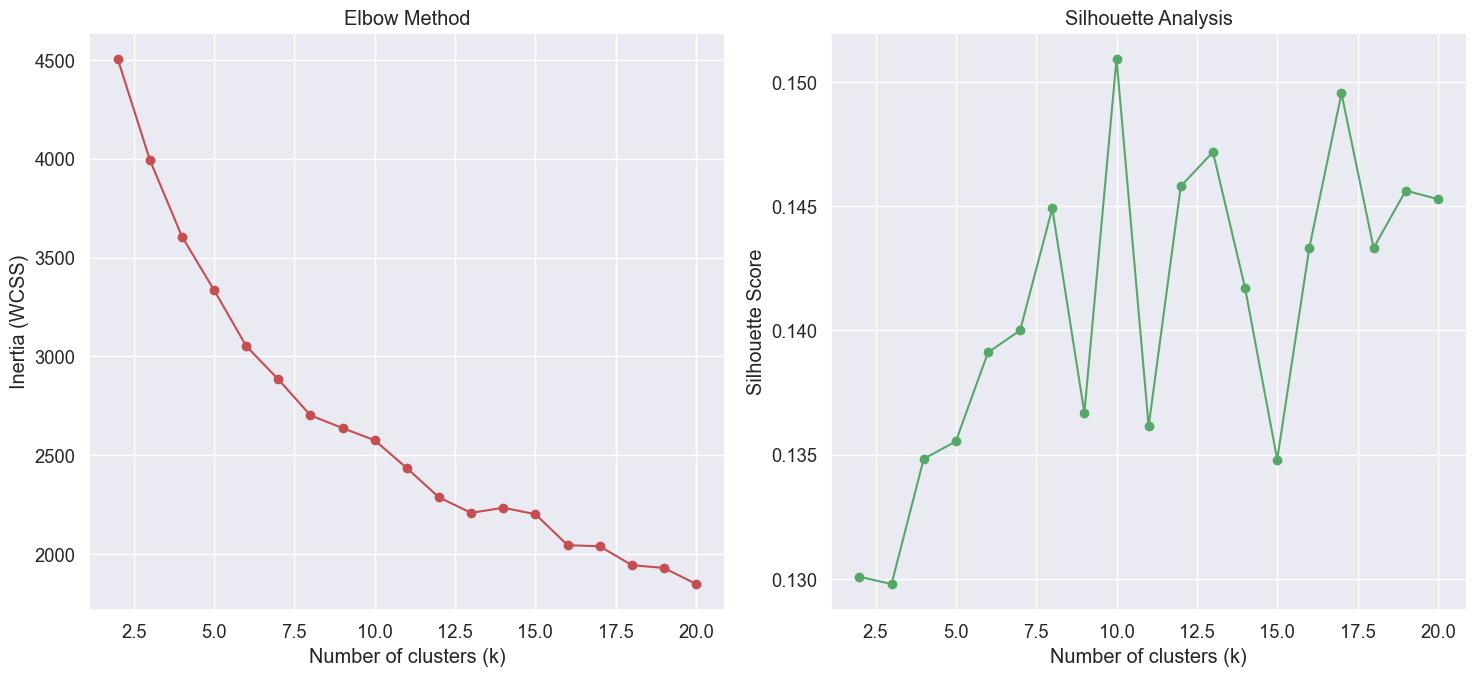

In [32]:
k_values = range(2, 21)
inertias = []
silhouette_scores = []

for k in k_values:
    test_kmeans = KMeansClustering(k=k, max_iter=1000)
    test_kmeans.fit(data_pca)

    inertia = -test_kmeans.score(data_pca)
    inertias.append(inertia)

    labels = test_kmeans.labels_
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(data_pca, labels)
    else:
        silhouette = np.nan
    silhouette_scores.append(silhouette)


plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, 'go-', scalex=True)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)

plt.tight_layout()
plt.show()

In [33]:
# Usando k=7
model.set_params(**{'kmeans__k': 10, 'pca__n_components': 0.6})

labels = model.fit_predict(X)

## Análise crítica final


In [34]:
# Number of elements per cluster
pd.DataFrame(labels).value_counts().sort_index()

0
0     83
1     97
2    112
3     83
4     99
5     94
6     99
7    114
8    118
9    101
Name: count, dtype: int64

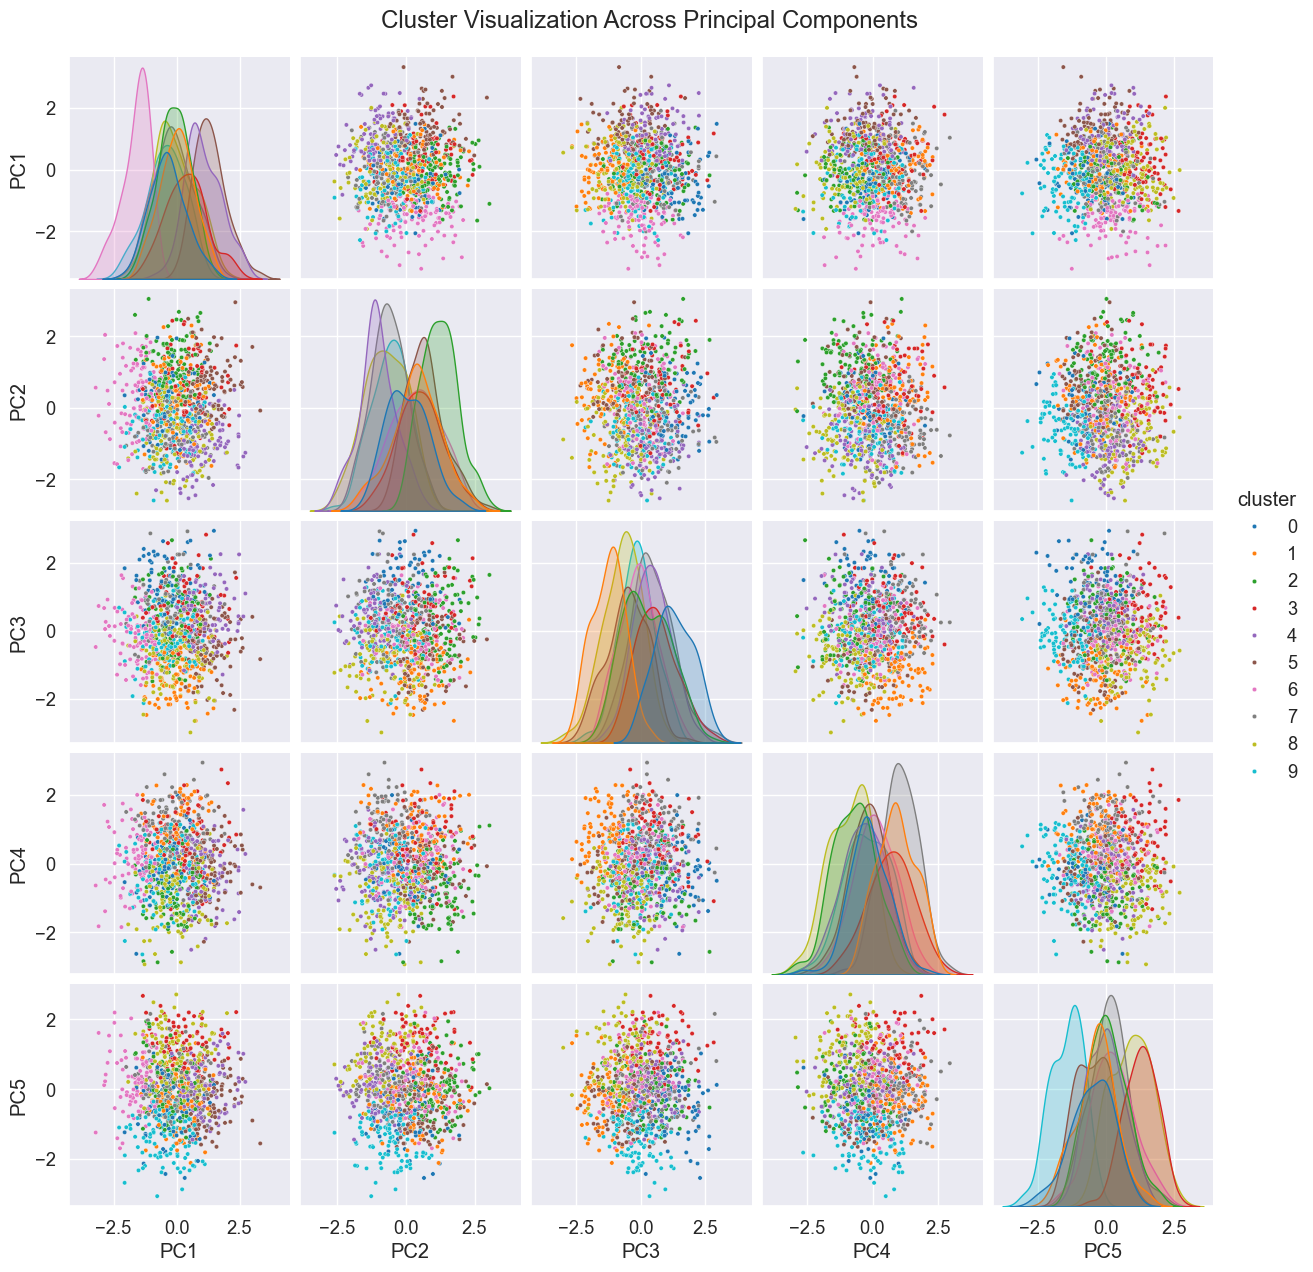

<Figure size 640x480 with 0 Axes>

In [35]:
# Convert PCA data to DataFrame
df_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
df_pca['cluster'] = labels
encoded_df['cluster'] = labels

sns.pairplot(
    df_pca,
    vars=df_pca.columns[:5],
    hue='cluster',
    palette='tab10',
    plot_kws={'s': 10},
)
plt.suptitle("Cluster Visualization Across Principal Components", y=1.02)
plt.show()

plt.suptitle("Cluster Visualization Across Principal Components", y=1.02)
plt.show()

In [36]:
# Obtendo dataset groupby
mean_groupby_cluster = encoded_df.groupby(by='cluster').mean().sort_values('exam_score')

mean_groupby_cluster

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
cluster,,,,,,,,,,,,,,,,,,,,
2,22.116071,2.666071,2.800000,1.802679,82.741964,7.181250,1.392857,3.044643,53.917857,0.455357,0.053571,0.142857,0.258929,0.214286,0.357143,0.178571,0.098214,0.526786,0.116071,0.276786
9,19.386139,2.757426,1.842574,2.439604,84.181188,5.225743,3.544554,3.574257,56.892079,0.504950,0.039604,0.198020,0.366337,0.178218,0.346535,0.198020,0.069307,0.376238,0.178218,0.396040
7,18.210526,2.456140,2.470175,1.110526,87.514912,6.758772,3.631579,6.307018,65.011404,0.447368,0.061404,0.254386,0.368421,0.236842,0.429825,0.131579,0.078947,0.350877,0.228070,0.289474
0,20.662651,3.197590,2.777108,3.369880,87.165060,6.957831,4.385542,5.951807,65.743373,0.542169,0.036145,0.265060,0.421687,0.180723,0.325301,0.108434,0.132530,0.481928,0.168675,0.277108
6,22.131313,2.723232,1.676768,1.806061,77.049495,7.059596,4.818182,5.505051,67.207071,0.595960,0.020202,0.222222,0.434343,0.232323,0.474747,0.161616,0.030303,0.484848,0.171717,0.343434
5,20.787234,4.506383,3.206383,1.456383,89.850000,5.975532,1.478723,2.882979,70.030851,0.446809,0.021277,0.297872,0.404255,0.148936,0.351064,0.223404,0.127660,0.489362,0.191489,0.329787
8,20.703390,3.811864,2.371186,1.426271,74.002542,5.884746,1.474576,7.635593,73.251695,0.500000,0.025424,0.220339,0.415254,0.152542,0.389831,0.220339,0.067797,0.432203,0.118644,0.347458
4,18.838384,4.463636,3.012121,2.594949,87.140404,5.900000,2.121212,7.818182,77.822222,0.424242,0.060606,0.181818,0.393939,0.171717,0.464646,0.111111,0.080808,0.494949,0.131313,0.262626
3,21.349398,4.200000,3.400000,1.410843,87.543373,7.845783,3.674699,7.746988,83.485542,0.409639,0.084337,0.180723,0.421687,0.180723,0.433735,0.096386,0.096386,0.409639,0.132530,0.313253


## Salvando modelos


In [37]:
# Criando pasta de modelos
!mkdir ../modelos

mkdir: ../modelos: File exists


In [38]:
# Salvando modelo
pickle.dump(model, open('../modelos/modelo_clusterizacao.pkl', 'wb'))

## Tarefas Extra


### DBSCAN

DBSCAN ou Density-Based Spatial Clustering of Applications with Noise, é um algoritmo para identificação de clusters em altas dimensionalidades. Ele funciona fazendo grupos com pontos chamados de "_core points_" para juntar pontos baseados em dois hiperparâmetros, `epsilon` e `min_samples` (na classe da biblioteca `sklearn`). O primeiro determina o raio do perímetro de cada ponto, enquanto o segundo define o número de pontos devem estar presentes no raio de determinado ponto, de forma que esse seja considerado _core point_.

Pontos são classificados de três maneiras, _core points_ que foram discutidos previamente, são responsáveis por selecionar outros pontos para serem incorporados ao cluster, _non-core points_, que não possuem em seu raio a quantidade necessária de pontos a se tornarem um _core point_, e _noise points_ que não são pontos pertencentes a nenhum cluster.

O funcionamento do algoritmo é dado da seguinte maneira:

1. Um ponto dentro do conjunto dos dados é escolhido de maneira aleatória. Caso esse ponto seja um _core point_ ele identificará todos os pontos em seu raio, que posteriormente serão investigados. Caso esse ponto seja _non-core_, um novo ponto ponto será escolhido.

2. Todos os _core points_ alcançáveis a partir de um ponto inicial são catalogados e adicionados a um cluster

3. em seguida o mesmo acontece aos _non-core points_, assim catalogando todos os pontos de um cluster.

4. Um novo ponto é escolhido aleatoriamente, e os passos 1-3 são repetidos até que todos os pontos do dataset sejam classificados.

Pontos que não são alcançados por nenhum _core point_ são _noise points_ e compõe um cluster. Cada cluster é adicionado de forma sequencialmente, assim apenas pontos que não fazem parte de outros clusters são alcançáveis a partir de um novo ponto aleatório. DBSCAN é um algoritmo que usa distâncias, portanto é necessário que pontos estejam normalizados.

---

**_Referências:_**

[DBSCAN Implementation and Parameter Tuning - TheDataPost](https://www.youtube.com/watch?v=uGPwx6XNY7Y)

[DBSCAN Explanation and Visualization - TheDataPost](https://www.youtube.com/watch?v=_A9Tq6mGtLI)

[Clustering with DBSCAN, Clearly Explained!!! - StatQuest](https://www.youtube.com/watch?v=RDZUdRSDOok)

[Introdução ao algoritmo DBSCAN - IA Expert Academy](https://www.youtube.com/watch?v=Lpd6HUtz580)

[DBSCAN Clustering in ML | Density based clustering - Geeks For Geeks](https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/)


#### Implementação nos dados


In [39]:
# Definindo pca para teste de cotovelo
pca = PCA(5)
data_pca = pca.fit_transform(data)

In [40]:
eps_values = np.linspace(0.1, 5.0, 30)
min_sample_values = np.linspace(1, 20, 20, dtype='int')

n_clusters_dict = {str(int(key)): [] for key in min_sample_values}
n_noise_dict = {str(int(key)): [] for key in min_sample_values}
silhouette_scores_dict = {str(int(key)): [] for key in min_sample_values}

for eps in eps_values:
    for min_sample_value in min_sample_values:
        db = DBSCAN(eps=eps, min_samples=min_sample_value).fit(data)
        labels = db.labels_

        # Number of clusters (excluding noise)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_clusters_dict[f'{min_sample_value}'].append(n_clusters)

        # Number of noise points
        n_noise = list(labels).count(-1)
        n_noise_dict[f'{min_sample_value}'].append(n_noise)

        # Silhouette score (only if at least 2 clusters)
        if n_clusters > 1 and len(set(labels)) > 1 and len(set(labels)) < len(data):

            silhouette = silhouette_score(data, labels)
        else:
            silhouette = np.nan
        silhouette_scores_dict[f'{min_sample_value}'].append(silhouette)

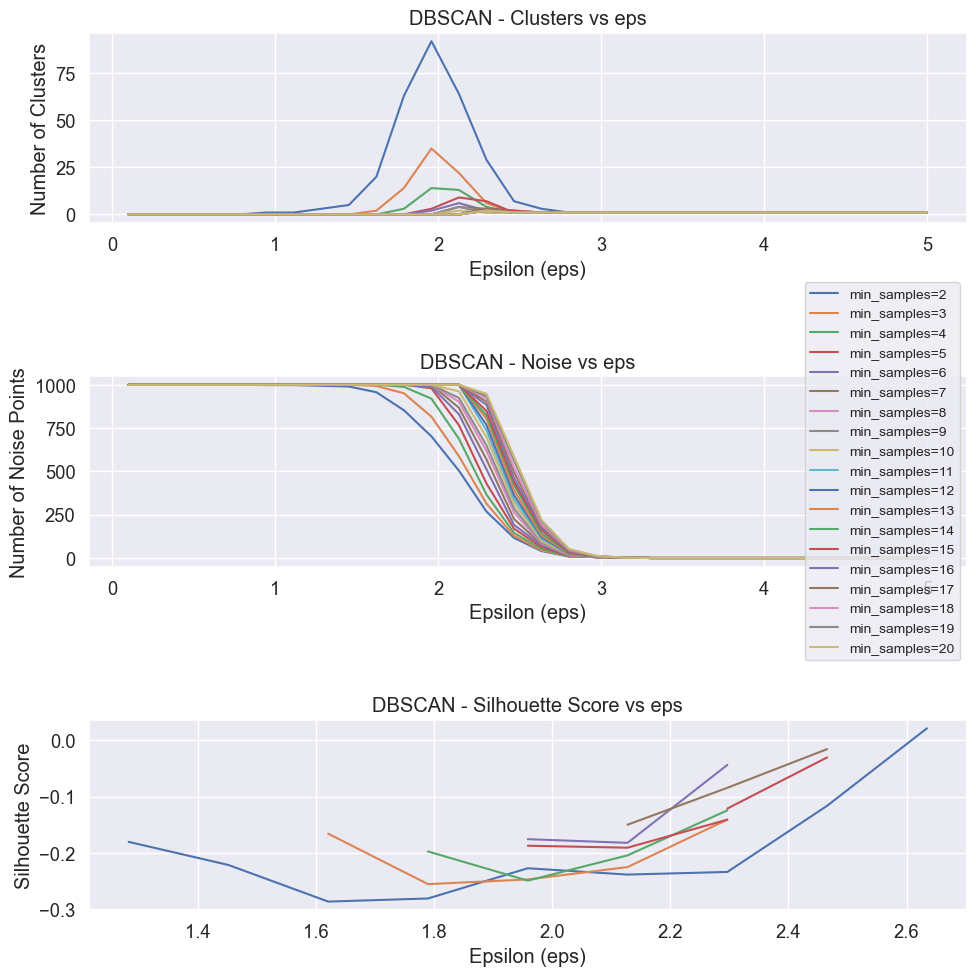

In [41]:
# Plotting
plt.figure(figsize=(10, 10))

# Plot number of clusters
plt.subplot(3, 1, 1)
for key in n_clusters_dict:
    if key != '1':
        plt.plot(eps_values, n_clusters_dict[key], label=f'min_samples={key}')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN - Clusters vs eps')
plt.grid(True)

# Plot number of noise points
plt.subplot(3, 1, 2)
for key in n_noise_dict:
    if key != '1':
        plt.plot(eps_values, n_noise_dict[key], label=f'min_samples={key}')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Number of Noise Points')
plt.title('DBSCAN - Noise vs eps')
plt.legend(loc='center right', prop={'size': 10})
plt.grid(True)

# Plot silhouette scores
plt.subplot(3, 1, 3)
for key in silhouette_scores_dict:
    if key != '1':
        plt.plot(eps_values, silhouette_scores_dict[key], label=f'min_samples={key}')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.title('DBSCAN - Silhouette Score vs eps')
plt.grid(True)
plt.tight_layout()
plt.show()

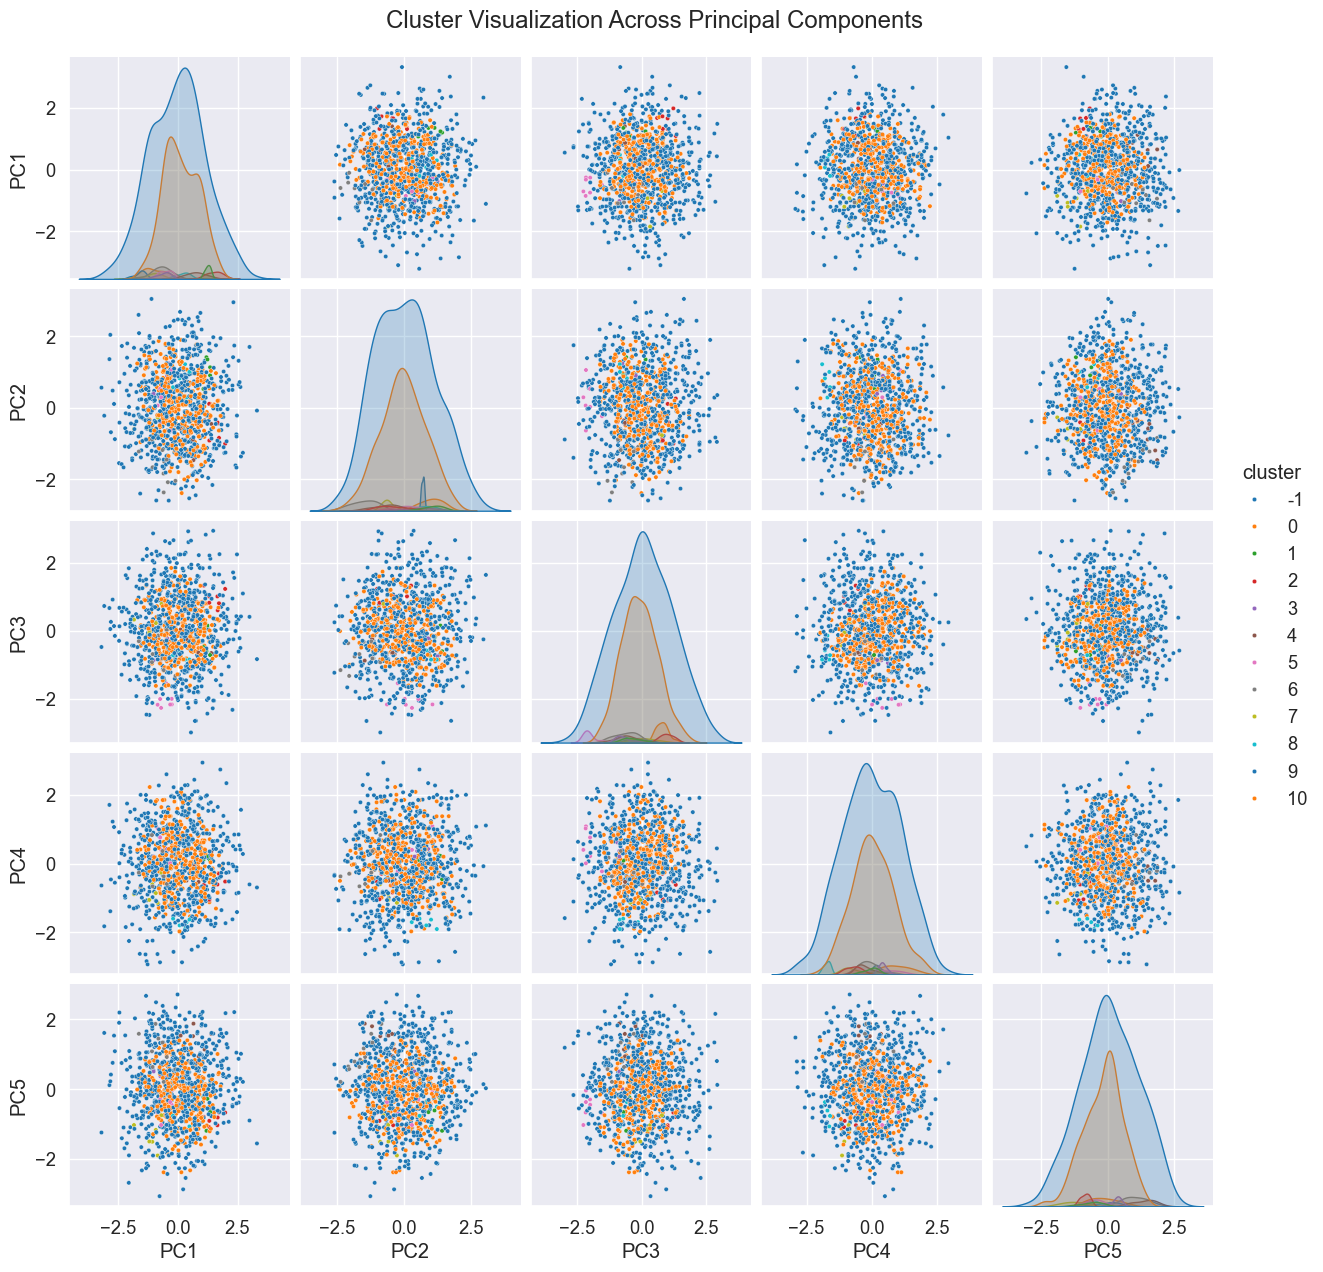

<Figure size 640x480 with 0 Axes>

In [48]:
# Convert PCA data to DataFrame
df_pca = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
df_pca['cluster'] = labels
encoded_df['cluster'] = labels

sns.pairplot(
    df_pca,
    vars=df_pca.columns[:5],
    hue='cluster',
    palette='tab10',
    plot_kws={'s': 10},
)
plt.suptitle("Cluster Visualization Across Principal Components", y=1.02)
plt.show()

plt.suptitle("Cluster Visualization Across Principal Components", y=1.02)
plt.show()

In [43]:
# Criando pipeline do modelo
dbscan = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.6)),
        ('model', DBSCAN(eps=1, min_samples=5)),
    ]
)

In [44]:
# Treinando modelo
labels = dbscan.fit_predict(X)

In [45]:
list(set(labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1]

In [46]:
# Number of elements per cluster
pd.DataFrame(labels).value_counts()

0  
-1     639
 0     285
 6      14
 10     14
 4       8
 2       7
 5       7
 7       6
 1       5
 3       5
 8       5
 9       5
Name: count, dtype: int64

In [47]:
# Vendo clusters criados

# Obtendo dataset groupby
encoded_df['cluster'] = labels
mean_groupby_cluster = encoded_df.groupby(by='cluster').mean().sort_values('exam_score')

mean_groupby_cluster

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,parental_education_level_Not Informed,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
cluster,,,,,,,,,,,,,,,,,,,,
8,22.000000,3.740000,2.540000,2.440000,77.260000,5.800000,0.600000,1.800000,53.080000,0.200000,0.000000,0.200000,0.200000,0.200000,0.400000,0.200000,0.000000,0.600000,0.000000,0.200000
7,20.000000,2.633333,1.533333,3.183333,78.600000,5.516667,3.833333,4.166667,53.616667,0.500000,0.000000,0.000000,0.500000,0.166667,0.333333,0.333333,0.000000,0.666667,0.000000,0.500000
3,21.000000,2.180000,1.340000,0.280000,84.360000,6.960000,1.600000,4.200000,58.900000,0.400000,0.000000,0.000000,0.200000,0.000000,0.600000,0.000000,0.000000,0.200000,0.200000,0.200000
10,20.785714,2.371429,2.435714,1.742857,86.035714,8.000000,5.142857,3.571429,62.207143,0.571429,0.000000,0.071429,0.214286,0.214286,0.285714,0.428571,0.071429,0.714286,0.000000,0.357143
9,22.600000,2.640000,1.640000,1.720000,80.080000,7.080000,5.000000,4.600000,68.480000,0.800000,0.000000,0.600000,0.600000,0.000000,0.800000,0.200000,0.000000,0.400000,0.000000,0.400000
0,20.259649,3.531930,2.454035,1.753333,85.261754,6.292632,2.870175,5.140351,68.898596,0.480702,0.038596,0.196491,0.368421,0.178947,0.368421,0.182456,0.091228,0.480702,0.161404,0.326316
-1,20.583725,3.569484,2.565884,1.864945,83.865102,6.558998,3.104851,5.579030,69.923005,0.477308,0.045383,0.231612,0.383412,0.194053,0.405321,0.151800,0.092332,0.425665,0.165884,0.308294
2,18.428571,4.642857,2.871429,3.571429,93.385714,6.342857,1.000000,5.571429,72.214286,0.285714,0.000000,0.142857,0.571429,0.000000,0.285714,0.142857,0.142857,0.857143,0.142857,0.285714
6,19.500000,3.285714,2.050000,1.121429,72.342857,5.792857,3.357143,9.071429,72.807143,0.500000,0.071429,0.071429,0.428571,0.142857,0.357143,0.142857,0.000000,0.142857,0.428571,0.428571


### Hierarchical Clustering

Associado com mapas de calor, onde colunas representam diferentes "samples" e as fileiras representam diferentes medidas de diferentes genes. Vermelho demonstra alta expressão de um gene, enquanto roxo ou azul representam menor expressão de um gene. _Hierarchical Clustering_ ordena as colunas/fileiras com base em similaridade, tornando fácil de visualizar as correlações nos dados. Mapas de calor são usualmente associados a dendrogramas.

Calcular a correlação para cada amostra individualmente, das diferentes combinações, descobrir quais duas amostras são mais similares e juntá-los em um cluster. Em seguida, faz se uma análise em cima de quais amostras são mais similares ao primeiro cluster.

Vez que todos os pontos foram clusterizados, esses clusters são juntos para forma um só. Dendrogramas nesse caso são usados para indicar a similaridades entre diferentes amostras, e a ordem na qual seus clusters foram formados. Dados com menores "galhos" são os mais similares e foram formados primeiro.

O método para determinar a similaridade entre dois pontos é arbitrário, contudo um método frequentemente usado para esse cálculo, é a distância euclidiana. A distância euclidiana entre duas amostras é calculada da seguinte maneira:

$$d(p, q) = \sqrt{ \sum_{i=1}^{n} (q_i - p_i)^2 }$$

Outro método de calcular essa distância é a distância de Manhattan, onde se toma o absoluto da diferença entre os dois pontos:

$$d(p, q) =  \sum_{i=1}^{n} |q_i - p_i| $$

---

_Hierarchical clustering_ é um método de clusterização que cria uma árvore hierárquica de objetos a serem clusterizados. A árvore representa a relação entre os diferentes objetos e mostra como eles são clusterizados em diferentes níveis.

Para racionalizar o processo, o primeiro passo seria similar a adicionar as amostras em um gráfico de dispersão. Cada amostra, inicialmente terá seu próprio cluster, assim existindo o mesmo número de clusters e de amostras. O objetivo é gradualmente juntar mais e mais clusters de modo que finalmente, todos os pontos pertençam a um mesmo cluster.

A cada passo, os clusters que estão mais próximos serão unidos. Para definir o que "mais próximos" significa, são necessárias duas análises, a primeira _como medir a distância entre dois pontos_, e a segunda _como pontos são conectados em um cluster_. Para a para medir a distância entre dois pontos, existem 3 principais algoritmos, a _distância Euclidiana_, a _distância de Manhattan_, e _a distância Máxima_.

$$d(p, q) = \sqrt{ \sum_{i=1}^{n} (q_i - p_i)^2 }$$
$$d(p, q) =  \sum_{i=1}^{n} |q_i - p_i| $$
$$d(p, q) = max(|q_i - p_i|) $$

A distância máxima usa o maior valor entre as duas distâncias.

Para definir como pontos são conectados em um cluster, existem 3 principais métodos, _single linkage_, _complete linkage_, e _average linkage_. _Single linkage_ usa a distância entre os elementos mais próximos em dois clusters. _Complete linkage_ usa a distância entre os dois elementos mais distantes de dois clusters. _Average linkage_ usa a média de todas as distâncias par a par dos clusters.

Os clusters de menor distâncias são unidos, e o processo se reinicia, e a cada conexão os dados são unidos através do dendrograma. Isso acontece até que todos os dados tenham sido agrupados.

---

[StatQuest: Hierarchical Clustering - StatQuest](https://www.youtube.com/watch?v=7xHsRkOdVwo)

[Hierarchical Cluster Analysis [Simply explained]](https://www.youtube.com/watch?v=8QCBl-xdeZI)

[What is hierarchical clustering](https://www.ibm.com/think/topics/hierarchical-clustering)

[Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)


- Treinamento com k clusters
- dendrograma
- elbow plot


### SotA para Clustering

https://peerj.com/articles/cs-2286.pdf

https://www.researchgate.net/publication/358814868_A_comprehensive_survey_of_clustering_algorithms_State-of-the-art_machine_learning_applications_taxonomy_challenges_and_future_research_prospects

https://medium.com/%40sina.nazeri/comparing-the-state-of-the-art-clustering-algorithms-1e65a08157a1
